<a href="https://colab.research.google.com/github/sthalles/book-resources/blob/main/chapter1/resnet_plain_network_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchmetrics torch-summary
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch.nn as nn
import torch
from torchvision import datasets, transforms
from torchsummary import summary
from torchmetrics import Accuracy
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
print("PyTorch version:", torch.__version__)

PyTorch version: 1.12.1+cu113


In [4]:
# !pip install -q netron
# !curl --output smartreply.zip https://storage.googleapis.com/download.tensorflow.org/models/tflite/smartreply_1.0_2017_11_01.zip
# !unzip smartreply.zip

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [6]:
class BasicBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
    self.bn = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace=True)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn(x)
    x = self.relu(x)
    return x

In [7]:
height = 32
width= 32
in_channels = 16
fake_input = torch.rand(1,3,height,width)

In [8]:
block = BasicBlock(3,in_channels,1)
out = block(fake_input)
assert out.shape == (1,in_channels,height,width), f"Unexpented shape of {out.shape}"

In [9]:
block = BasicBlock(3,16,2)
out = block(fake_input)
assert out.shape == (1,in_channels,height//2,width//2), f"Unexpented shape of {out.shape}"

In [10]:
class PlainNetwork(nn.Module):
  def __init__(self, n):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=1)
  
    self.layer1 = self.make_layer(16, out_channels=16, stride=1, n_layers=2*n)
    self.layer2 = self.make_layer(16, out_channels=32, stride=2, n_layers=2*n)
    self.layer3 = self.make_layer(32, out_channels=64, stride=2, n_layers=2*n)
    self.global_pooling = nn.AdaptiveAvgPool2d((1,1))
    self.linear = nn.Linear(64, 10)

  def make_layer(self, in_channels, out_channels, stride, n_layers):
    layer = []
    layer.append(BasicBlock(in_channels, out_channels, stride))
    for i in range(n_layers-1):
      layer.append(BasicBlock(out_channels, out_channels, 1))
    return nn.Sequential(*layer)

  def forward(self, x):
    x = self.conv1(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.global_pooling(x)
    x = torch.flatten(x, 1)
    x = self.linear(x)
    return x

In [11]:
model = PlainNetwork(n=1)
model = model.to(device)
summary(model, (3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 32, 32]          448
├─Sequential: 1-2                        [-1, 16, 32, 32]          --
|    └─BasicBlock: 2-1                   [-1, 16, 32, 32]          --
|    |    └─Conv2d: 3-1                  [-1, 16, 32, 32]          2,320
|    |    └─BatchNorm2d: 3-2             [-1, 16, 32, 32]          32
|    |    └─ReLU: 3-3                    [-1, 16, 32, 32]          --
|    └─BasicBlock: 2-2                   [-1, 16, 32, 32]          --
|    |    └─Conv2d: 3-4                  [-1, 16, 32, 32]          2,320
|    |    └─BatchNorm2d: 3-5             [-1, 16, 32, 32]          32
|    |    └─ReLU: 3-6                    [-1, 16, 32, 32]          --
├─Sequential: 1-3                        [-1, 32, 16, 16]          --
|    └─BasicBlock: 2-3                   [-1, 32, 16, 16]          --
|    |    └─Conv2d: 3-7                  [-1, 32, 16, 16]          4,640
|    

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 32, 32]          448
├─Sequential: 1-2                        [-1, 16, 32, 32]          --
|    └─BasicBlock: 2-1                   [-1, 16, 32, 32]          --
|    |    └─Conv2d: 3-1                  [-1, 16, 32, 32]          2,320
|    |    └─BatchNorm2d: 3-2             [-1, 16, 32, 32]          32
|    |    └─ReLU: 3-3                    [-1, 16, 32, 32]          --
|    └─BasicBlock: 2-2                   [-1, 16, 32, 32]          --
|    |    └─Conv2d: 3-4                  [-1, 16, 32, 32]          2,320
|    |    └─BatchNorm2d: 3-5             [-1, 16, 32, 32]          32
|    |    └─ReLU: 3-6                    [-1, 16, 32, 32]          --
├─Sequential: 1-3                        [-1, 32, 16, 16]          --
|    └─BasicBlock: 2-3                   [-1, 32, 16, 16]          --
|    |    └─Conv2d: 3-7                  [-1, 32, 16, 16]          4,640
|    

In [13]:
# convert to onnx format
model_path = "./plainnet.pth"
_ = torch.onnx.export(model.to(device), fake_input.to(device), model_path)

In [14]:
# import netron
# import portpicker
# from google.colab import output

# port = portpicker.pick_unused_port()

# # Read the model file and start the netron browser.
# with output.temporary():
#   netron.start(model_path, port, browse=False)

# output.serve_kernel_port_as_iframe(port, height='800')

In [15]:
## training parameters
weight_decay = 0.0001
momentum = 0.9
batch_size = 128
learning_rate = 0.1

In [16]:
## We follow the simple data augmen-tation in [24] for training: 4 pixels
## are padded on each side, and  a  32×32  crop  is  randomly  sampled  from  
## the  padded image or its horizontal flip.  For testing, we only evaluate the
## single view of the original 32×32 image

train_augmentations = transforms.Compose([
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomCrop(size=32, padding=4, fill=0, padding_mode='constant'),
     transforms.ToTensor()])

test_augmentations = transforms.Compose([
    transforms.ToTensor()
])

In [17]:
train_dataset = datasets.CIFAR10(root=".", train = True, download=True, transform=train_augmentations)
test_dataset = datasets.CIFAR10(root=".", train=False, transform=test_augmentations)

Files already downloaded and verified


In [18]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=True, sampler=None, drop_last=True, 
                                           num_workers=0)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                           shuffle=False, sampler=None, num_workers=0)

In [19]:
total_epochs = round(64_000 / len(train_loader))
lr_step1 = round(32_000 / len(train_loader))
lr_step2 = round(48_000 / len(train_loader))
print(f"Train for {total_epochs} epochs.")
print(f"Learning rate decreases at epochs {lr_step1} and {lr_step2}")

Train for 164 epochs.
Learning rate decreases at epochs 82 and 123


In [20]:
class Trainer:
    
    def __init__(self, epochs, optimizer, lr_scheduler, device):
        self.epochs = epochs
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.accuracy = Accuracy(num_classes=10).to(device)
        self.training_error = []
        self.testing_error = []
        self.loss_fn = nn.CrossEntropyLoss().to(device)
        
    def fit(self, model, train_loader, test_loader):
        iter = 0
        for epoch in tqdm(range(self.epochs)):
            train_error = 0

            model.train()
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                logits = model(x_batch)
                loss = self.loss_fn(logits, y_batch)
                
                train_acc = 100 * self.accuracy(logits, y_batch)
                train_error += (100 - train_acc)
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # if iter % 10 == 0:
                #   print(f"Epoch: {epoch}\tLoss: {loss}")

                iter += 1

            self.lr_scheduler.step()
            train_error /= len(train_loader)
            self.training_error.append(train_error.item())

            model.eval()
            test_error = 0

            with torch.no_grad():
                for x_batch, y_batch in test_loader:
                    x_batch = x_batch.to(device)
                    y_batch = y_batch.to(device)
                    logits = model(x_batch)

                    test_acc = 100 * self.accuracy(logits, y_batch)
                    test_error += (100 - test_acc)

                test_error /= len(test_loader)
                self.testing_error.append(test_error.item())

## Running the plain CNN for n=3

In [21]:
plainet20 = PlainNetwork(n=3)
plainet20 = plainet20.to(device)

In [22]:
optimizer = torch.optim.SGD(plainet20.parameters(), lr=learning_rate, 
                            weight_decay=weight_decay, momentum=momentum)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[lr_step1, lr_step2], gamma=0.1)

In [23]:
trainer20 = Trainer(total_epochs, optimizer, scheduler, device)

In [24]:
trainer20.fit(plainet20, train_loader, test_loader)

100%|██████████| 164/164 [51:52<00:00, 18.98s/it]


## Running the plain CNN for n=5

In [29]:
plainet32 = PlainNetwork(n=5)
plainet32 = plainet32.to(device)

In [30]:
optimizer = torch.optim.SGD(plainet32.parameters(), lr=learning_rate, 
                            weight_decay=weight_decay, momentum=momentum)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[lr_step1, lr_step2], gamma=0.1)

In [31]:
trainer32 = Trainer(total_epochs, optimizer, scheduler, device)

In [33]:
trainer32.fit(plainet32, train_loader, test_loader)

100%|██████████| 164/164 [1:01:09<00:00, 22.38s/it]


## Running the plain CNN for n=7

In [49]:
plainet44 = PlainNetwork(n=7)
plainet44 = plainet44.to(device)

In [50]:
optimizer = torch.optim.SGD(plainet44.parameters(), lr=learning_rate, 
                            weight_decay=weight_decay, momentum=momentum)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[lr_step1, lr_step2], gamma=0.1)

In [51]:
trainer44 = Trainer(total_epochs, optimizer, scheduler, device)

In [52]:
trainer44.fit(plainet44, train_loader, test_loader)

100%|██████████| 164/164 [1:12:11<00:00, 26.41s/it]


## Comparing and Visualizing training and test errors

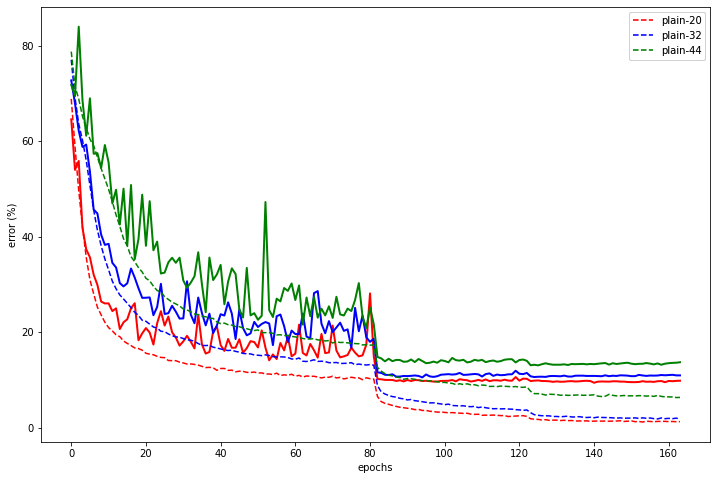

In [56]:
def add_lines(ax, train_error, test_error, color, label):
  line, = ax.plot(train_error, label=label, color=color, linestyle='--')
  _, = ax.plot(test_error, color=color, linewidth=2)
  return line

fig, ax = plt.subplots(figsize=(12,8))
line1 = add_lines(ax, trainer20.training_error, trainer20.testing_error, color="red", label="plain-20")
line2 = add_lines(ax, trainer32.training_error, trainer32.testing_error, color="blue", label="plain-32")
line3 = add_lines(ax, trainer44.training_error, trainer44.testing_error, color="green", label="plain-44")

# Create a legend for the first line.
legend = ax.legend(handles=[line1, line2, line3], loc='upper right')

# Add the legend manually to the Axes.
ax.add_artist(legend)
ax.set_xlabel('epochs')
ax.set_ylabel('error (%)')

plt.savefig("plain-nets-experiment.svg")
plt.show()

In [58]:
import pandas as pd

In [67]:
df = pd.DataFrame({"epoch": range(len(trainer20.training_error)),
              "plain-20-train-err": trainer20.training_error,
              "plain-20-test-err": trainer20.testing_error,
              "plain-32-train-err": trainer32.training_error,
              "plain-32-test-err": trainer32.testing_error,
              "plain-44-train-err": trainer44.training_error,
              "plain-44-test-err": trainer44.testing_error})
df.to_csv('plain_net_experiment.csv', index=False)

In [69]:
df.head()

,epoch,plain-20-train-err,plain-20-test-err,plain-32-train-err,plain-32-test-err,plain-44-train-err,plain-44-test-err
0,0,68.824120,64.556961,77.003204,72.705696,78.727966,71.746445
1,1,58.818111,53.965588,69.100563,67.899529,71.452324,69.462029
2,2,49.641426,55.844543,63.567711,62.153877,68.820114,83.949768
3,3,42.107372,41.851269,60.204330,58.781647,65.206329,68.621445
4,4,35.701122,37.361553,55.993591,59.256332,62.770435,61.125397
